In [237]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import scipy
from scipy.optimize import minimize

In [238]:
df_cov = pd.read_csv(r'Data/df_sp500_cov.csv', index_col = 0)
df_return= pd.read_csv(r'Data\df_sp500_price.csv', index_col = 0)
df_SP500_returns = pd.read_csv('Data\sp500_raw_data.csv', index_col = 0)

In [239]:
df_cov.iloc[0:5, 0:5]

,MMM,AOS,ABT,ABBV,ACN
Tickers,,,,,
MMM,0.000341,0.000180,0.000121,0.000092,0.000155
AOS,0.000180,0.000361,0.000113,0.000080,0.000163
ABT,0.000121,0.000113,0.000271,0.000116,0.000163
ABBV,0.000092,0.000080,0.000116,0.000232,0.000109
ACN,0.000155,0.000163,0.000163,0.000109,0.000332


Defining all the equation that we need to consider

In [240]:
# Define the objective function to minimize (portfolio variance)
# Based on an equation
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

#get the value of the covariance matrix
cov_matrix = df_cov.values

# Define the Sharpe ratio
def sharpe_r(weights, expected_returns, daily_rf_rate):
    # Calculate the portfolio's expected return
    portfolio_earnings= np.sum(weights * expected_returns)
    # Calculate the portfolio's variance
    port_variance = portfolio_variance(weights, cov_matrix)
    # Calculate the portfolio's standard deviation (risk)
    port_std_dev = np.sqrt(port_variance)
    # Calculate the Sharpe ratio
    return ( portfolio_earnings - daily_rf_rate) / port_std_dev

# Defined the expected return 
def port_er(x):
    return sum(x * df_return['Return'])

Getting the risk of t bills and return of index fund for the average to compare against.Inmporting in the price data so we can graph the change

In [241]:
import yfinance as yf

# Get the 3-month Treasury bill rate
t_bill = yf.Ticker("^IRX")
t_bill_rate = t_bill.history(period="1d")['Close'].iloc[-1]

# Convert to annual rate (assuming t_bill_rate is in percentage)
annual_rf_rate = (t_bill_rate / 100) * 4

# Convert to daily risk-free rate
daily_rf_rate = (1 + annual_rf_rate) ** (1 / 252) - 1

print(f"3-Month Treasury Bill Rate: {t_bill_rate:.2f}%")
print(f"Daily Risk-Free Rate: {daily_rf_rate:.8f}")

3-Month Treasury Bill Rate: 4.51%
Daily Risk-Free Rate: 0.00065769


In [242]:
import yfinance as yf

# Get the 3-month Treasury bill rate
t_bill = yf.Ticker("^IRX")
t_bill_rate = t_bill.history(period="1d")['Close'].iloc[-1]

# Convert to annual rate (assuming t_bill_rate is in percentage)
annual_rf_rate = (t_bill_rate / 100) * 4

# Convert to daily risk-free rate
daily_rf_rate = (1 + annual_rf_rate) ** (1 / 252) - 1

print(f"3-Month Treasury Bill Rate: {t_bill_rate:.2f}%")
print(f"Daily Risk-Free Rate: {daily_rf_rate:.8f}")

3-Month Treasury Bill Rate: 4.51%
Daily Risk-Free Rate: 0.00065769


In [243]:
# Download historical data for the index fund (e.g., S&P 500 ETF)
index_fund = yf.download('SPY', start='2019-08-30', end='2024-08-30')

# Calculate daily percentage change of the adjusted closing prices
index_fund = index_fund['Adj Close'].pct_change()

# Create a DataFrame to track cumulative returns of the index fund
df_index_fund = pd.DataFrame(
    ((1 + index_fund).cumprod() - 1)  # Calculate cumulative product and subtract 1 to get cumulative returns
)

# Reset the index to turn the index into a column
df_index_fund.reset_index(inplace=True)

# Convert 'Date' column to datetime format
df_index_fund['Date'] = pd.to_datetime(df_index_fund['Date'])

# Set 'Date' column as the index
df_index_fund.set_index('Date', inplace=True)

# Display the DataFrame
df_index_fund

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2019-08-30,NaN
2019-09-03,-0.005847
2019-09-04,0.005437
2019-09-05,0.018363
2019-09-06,0.019149
...,...
2024-08-23,1.079644
2024-08-26,1.074686
2024-08-27,1.077535


The section finds the Global Variance Optimization, the lowest portfolio variance there is

In [244]:
### How to run a minimize optimization problem

# Initial guess for the weights (random weights that sum to 1)
# Create as many weights as there are tickers
np.random.seed(42)
initial_weights = np.array([1.00 / len(df_cov)] * len(df_cov))

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) # all weights sum to 1

# Bounds: weights must be between 0 and 1
bounds = [(0, 1) for _ in range(len(initial_weights))]

# Minimize the portfolio variance
# args provide the second portion of the portfolio_variance function
result = minimize(
    portfolio_variance, #the equation that we want to minimize
    initial_weights, #the initial guess
    args=(cov_matrix,) #additional variables data
    , method='SLSQP' 
    , bounds=bounds, constraints=constraints
    , options={'disp': True} #to see the process
    )

# Optimal weights
weights = result.x


Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.434883978527082e-05
            Iterations: 23
            Function evaluations: 11523
            Gradient evaluations: 23


Cleaning up data

Weights: [8.20878279e-04 1.15338071e-03 2.06495568e-03 1.19951305e-02
 5.06525702e-19 0.00000000e+00 1.82959117e-19 2.16840434e-19
 2.21922632e-19 1.01643954e-19]
Global Minimum Portfolio Variance:  0.0086
Portfolio Expected Return:  0.0004
Annualized Return: 0.1172
Annualized Risk: 0.1369
Sharpe Ratio:-0.025
           Return      Risk  Min_risk_weights
Tickers                                      
MMM      0.000150  0.018460             0.001
AOS      0.000524  0.018989             0.001
ABT      0.000291  0.016467             0.002
ABBV     0.001042  0.015228             0.012
ABNB    -0.000231  0.031632             0.007
...           ...       ...               ...
WEC      0.000101  0.016649             0.005
WST      0.000625  0.021655             0.001
WTW      0.000364  0.017272             0.002
XEL      0.000082  0.016122             0.003
YUM      0.000190  0.016233             0.004

[137 rows x 3 columns]


C:\Users\david\AppData\Local\Temp\ipykernel_11052\2621006485.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later


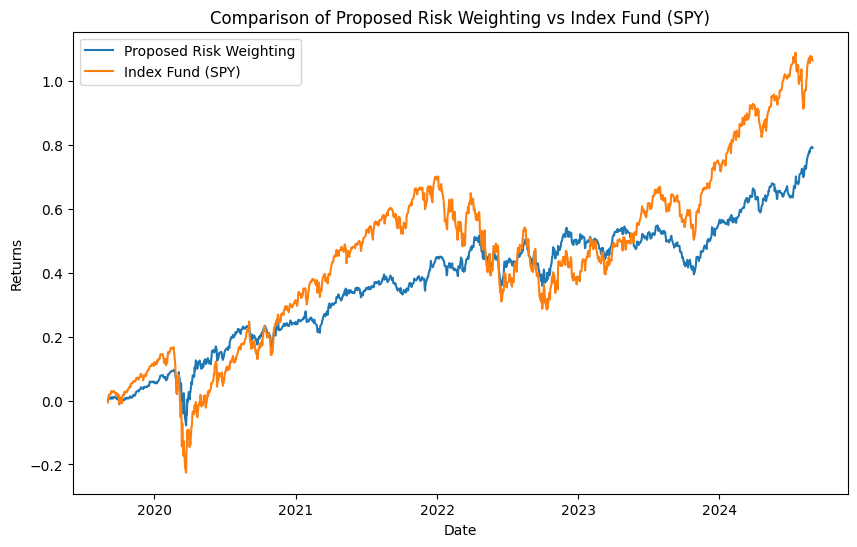

In [245]:
## Calculate the risk and return, then annualize it

# Calculate the minimum portfolio variance (risk)
minimum_portfolio_variance = np.sqrt(portfolio_variance(weights, cov_matrix))

# Calculate the expected return of the portfolio
minimum_port_e_r = sum(weights * df_return['Return'])

print("Weights:", weights[0:10])
print("Global Minimum Portfolio Variance: ", f'{minimum_portfolio_variance:.4f}')
print('Portfolio Expected Return: ', f'{minimum_port_e_r:.4f}')

# Annualize the return
min_risk_annualized_return = (1 + minimum_port_e_r) ** 252 - 1
print(f"Annualized Return: {min_risk_annualized_return:.4f}")

# Annualize the risk (standard deviation)
min_risk_annualized_risk = minimum_portfolio_variance * np.sqrt(252)
print(f"Annualized Risk: {min_risk_annualized_risk:.4f}")

#print sharpe return
print(f"Sharpe Ratio:{sharpe_r(weights, minimum_port_e_r, daily_rf_rate):.3f}")

## Create a column with the new weight

# Copy the df_return dataframe
df_temp = df_return.copy()

# Add the 'Min_risk_weights' column to df_temp with the calculated weights
df_temp['Min_risk_weights'] = weights

# Round the 'Min_risk_weights' column to 3 decimal places
df_temp['Min_risk_weights'] = df_temp['Min_risk_weights'].round(decimals=3)

# Filter the dataframe to include only rows where 'Min_risk_weights' is not zero
# Reset the index and make a copy of the filtered dataframe
df_min_risk_weight = df_temp[df_temp['Min_risk_weights'] != 0].reset_index().copy()

# Set the 'Tickers' column as the index of the dataframe
df_min_risk_weight.set_index('Tickers', inplace=True)

# Display the dataframe
print(df_min_risk_weight)

##graphing portion
# Create a DataFrame for the cumulative returns of the proposed risk weighting
df_plot = pd.DataFrame(
    (1 + df_SP500_returns[df_min_risk_weight.index.to_list()]  # Select returns for the dates in df_min_risk_weight
     .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later
     .pct_change()  # Calculate daily percentage change
     .dot(df_min_risk_weight.iloc[:, 2].values)  # Dot product with the risk weights
    ).cumprod() - 1  # Calculate cumulative product and subtract 1 to get cumulative returns
)

# Rename the columns to 'Returns' and set the index name to 'Date'
df_plot.columns = ['Returns']
df_plot.index.name = 'Date'

# Convert the index to datetime format
df_plot.index = pd.to_datetime(df_plot.index)

# Create a DataFrame to track cumulative returns of the index fund
df_index_fund = pd.DataFrame(
    ((1 + index_fund).cumprod() - 1)
)

# Plot both dataframes on the same graph
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['Returns'], label='Proposed Risk Weighting')
plt.plot(df_index_fund.index, df_index_fund.iloc[:, 0], label='Index Fund (SPY)')

# Adding title and labels
plt.title('Comparison of Proposed Risk Weighting vs Index Fund (SPY)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()


This portion is to figure out the best optimal weights by maximizing the expected return

In [246]:
# Assuming df_return has columns 'risk' and 'return'
# Initial guess for the weights (random weights that sum to 1)
np.random.seed(42)
np.random.seed(42)
initial_weights = np.array([1.00 / len(df_cov)] * len(df_cov))

#defined the reverse of it, to use minimize 
def neg_port_er(x):
    return -port_er(x)

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights must be between 0 and 1
#using the range function to create a list of 27 bounds
bounds = [(0, 1) for _ in range(len(initial_weights))]

# Minimize the portfolio variance
result = minimize(neg_port_er, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
weights = result.x


Weights: [2.51912461e-17 6.54584645e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.49368965e-18 0.00000000e+00 5.05299782e-18
 1.41204486e-17 5.40962328e-18]
Global Minimum Portfolio Variance:  0.0258
Portfolio Expected Return:  0.0026
Annualized Return: 0.9172
Annualized Risk: 0.4094
Sharpe Ratio:0.075
           Return      Risk  Max_risk_weights
Tickers                                      
CEG      0.002379  0.025558             0.168
GEV      0.002844  0.032370             0.291
NVDA     0.002660  0.033361             0.243
SMCI     0.002523  0.042461             0.207
TSLA     0.002085  0.041309             0.091


C:\Users\david\AppData\Local\Temp\ipykernel_11052\1561234537.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later


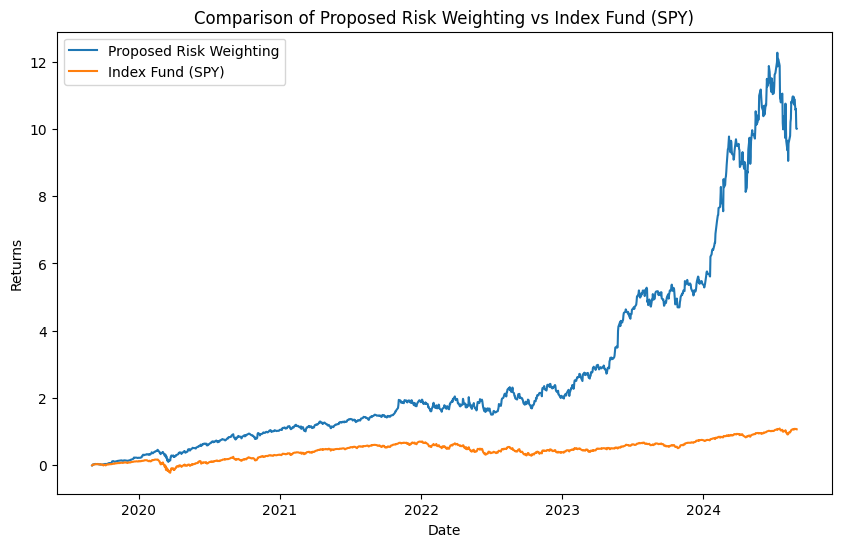

In [247]:
## Calculate the risk and return, then annualize it

# Calculate the minimum portfolio variance (risk)
max_return_portfolio_variance = np.sqrt(portfolio_variance(weights, cov_matrix))

# Calculate the expected return of the portfolio
max_return_port_e_r = sum(weights * df_return['Return'])

print("Weights:", weights[0:10])
print("Global Minimum Portfolio Variance: ", f'{max_return_portfolio_variance:.4f}')
print('Portfolio Expected Return: ', f'{max_return_port_e_r:.4f}')

# Annualize the return
max_return_annualized_return = (1 + max_return_port_e_r) ** 252 - 1
print(f"Annualized Return: {max_return_annualized_return:.4f}")

# Annualize the risk (standard deviation)
max_return_annualized_risk = max_return_portfolio_variance * np.sqrt(252)
print(f"Annualized Risk: {max_return_annualized_risk:.4f}")

#print sharpe return
print(f"Sharpe Ratio:{sharpe_r(weights, max_return_port_e_r, daily_rf_rate):.3f}")


## Create a column with the new weight

# Copy the df_return dataframe
df_temp = df_return.copy()

# Add the 'Max_risk_weights' column to df_temp with the calculated weights
df_temp['Max_risk_weights'] = weights

# Round the 'Min_risk_weights' column to 3 decimal places
df_temp['Max_risk_weights'] = df_temp['Max_risk_weights'].round(decimals=3)

# Filter the dataframe to include only rows where 'Max_risk_weights' is not zero
# Reset the index and make a copy of the filtered dataframe
df_max_return_weight = df_temp[df_temp['Max_risk_weights'] != 0].reset_index().copy()

# Set the 'Tickers' column as the index of the dataframe
df_max_return_weight.set_index('Tickers', inplace=True)

# Display the dataframe
print(df_max_return_weight)

##graphing portion
# Create a DataFrame for the cumulative returns of the proposed risk weighting
df_plot = pd.DataFrame(
    (1 + df_SP500_returns[df_max_return_weight.index.to_list()]  # Select returns for the dates in df_min_risk_weight
     .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later
     .pct_change()  # Calculate daily percentage change
     .dot(df_max_return_weight.iloc[:, 2].values)  # Dot product with the risk weights
    ).cumprod() - 1  # Calculate cumulative product and subtract 1 to get cumulative returns
)

# Rename the columns to 'Returns' and set the index name to 'Date'
df_plot.columns = ['Returns']
df_plot.index.name = 'Date'

# Convert the index to datetime format
df_plot.index = pd.to_datetime(df_plot.index)

# Create a DataFrame to track cumulative returns of the index fund
df_index_fund = pd.DataFrame(
    ((1 + index_fund).cumprod() - 1)
)

# Plot both dataframes on the same graph
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['Returns'], label='Proposed Risk Weighting')
plt.plot(df_index_fund.index, df_index_fund.iloc[:, 0], label='Index Fund (SPY)')

# Adding title and labels
plt.title('Comparison of Proposed Risk Weighting vs Index Fund (SPY)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()

This portion is to optimize the Sharpe ratio which is the return /risk rati

In [248]:
# Initial guess for the weights (random weights that sum to 1)
np.random.seed(42)
initial_weights = np.array([1.00 / len(df_cov)] * len(df_cov))

# Define the negative Sharpe ratio to use with minimize
def neg_sharpe_r(weights, expected_returns, daily_rf_rate):
    return -sharpe_r(weights, expected_returns, daily_rf_rate)

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights must be between 0 and 1
bounds = [(0, 1) for _ in range(len(initial_weights))]

# Assuming df_return contains the expected returns
expected_returns = df_return['Return'].values

# Minimize the negative Sharpe ratio to maximize the Sharpe ratio
result = minimize(neg_sharpe_r, initial_weights, args=(expected_returns, daily_rf_rate), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
weights = result.x

Weights: [2.88811587e-16 1.96627312e-15 0.00000000e+00 3.50269448e-16
 8.94348169e-17 0.00000000e+00 6.42109071e-17 3.70704056e-16
 0.00000000e+00 5.94138331e-18]
Global Minimum Portfolio Variance:  0.0130
Portfolio Expected Return:  0.0019
Annualized Return: 0.6132
Annualized Risk: 0.4094
Sharpe Ratio:0.096
           Return      Risk  Max_sharpe_weights
Tickers                                        
CARR     0.001643  0.023947               0.030
CEG      0.002379  0.025558               0.200
GEV      0.002844  0.032370               0.011
LLY      0.001742  0.019877               0.214
MCK      0.001137  0.018097               0.058
NVDA     0.002660  0.033361               0.113
VLTO     0.001612  0.015654               0.373


C:\Users\david\AppData\Local\Temp\ipykernel_11052\2455313168.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later


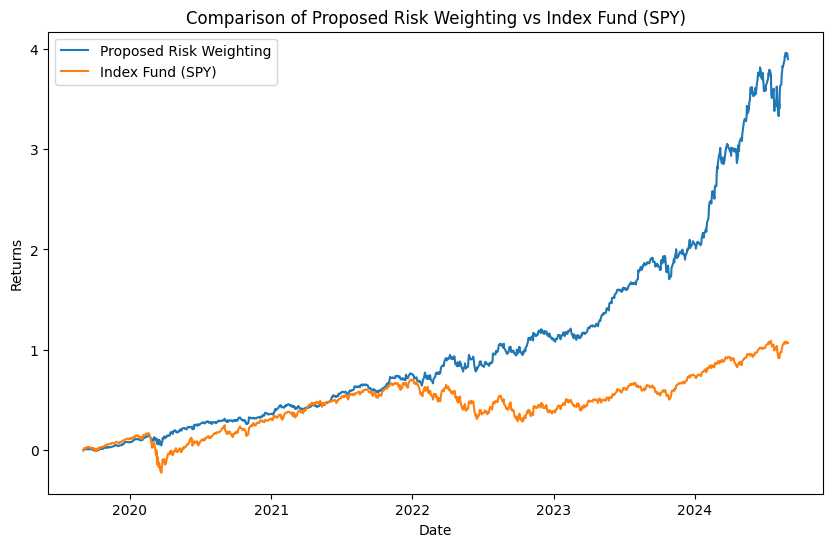

In [249]:
## Calculate the risk and return, then annualize it

# Calculate the minimum portfolio variance (risk)
max_sharpe_portfolio_variance = np.sqrt(portfolio_variance(weights, cov_matrix))

# Calculate the expected return of the portfolio
max_sharpe_port_e_r = sum(weights * df_return['Return'])

print("Weights:", weights[0:10])
print("Global Minimum Portfolio Variance: ", f'{max_sharpe_portfolio_variance:.4f}')
print('Portfolio Expected Return: ', f'{max_sharpe_port_e_r:.4f}')

# Annualize the return
max_sharpe_annualized_return = (1 + max_sharpe_port_e_r) ** 252 - 1
print(f"Annualized Return: {max_sharpe_annualized_return:.4f}")

# Annualize the risk (standard deviation)
max_sharpe_annualized_risk = max_return_portfolio_variance * np.sqrt(252)
print(f"Annualized Risk: {max_sharpe_annualized_risk:.4f}")

#print sharpe return
print(f"Sharpe Ratio:{sharpe_r(weights, max_sharpe_port_e_r, daily_rf_rate):.3f}")


## Create a column with the new weight

# Copy the df_return dataframe
df_temp = df_return.copy()

# Add the 'Max_sharpe_weights' column to df_temp with the calculated weights
df_temp['Max_sharpe_weights'] = weights

# Round the 'Max_sharpe_weights' column to 3 decimal places
df_temp['Max_sharpe_weights'] = df_temp['Max_sharpe_weights'].round(decimals=3)

# Filter the dataframe to include only rows where 'Max_sharpe_weights' is not zero
# Reset the index and make a copy of the filtered dataframe
df_max_sharpe_weight = df_temp[df_temp['Max_sharpe_weights'] != 0].reset_index().copy()

# Set the 'Tickers' column as the index of the dataframe
df_max_sharpe_weight.set_index('Tickers', inplace=True)

# Display the dataframe
print(df_max_sharpe_weight)

##graphing portion
# Create a DataFrame for the cumulative returns of the proposed risk weighting
df_plot = pd.DataFrame(
    (1 + df_SP500_returns[df_max_sharpe_weight.index.to_list()]  # Select returns for the dates in df_min_risk_weight
     .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later
     .pct_change()  # Calculate daily percentage change
     .dot(df_max_sharpe_weight.iloc[:, 2].values)  # Dot product with the risk weights
    ).cumprod() - 1  # Calculate cumulative product and subtract 1 to get cumulative returns
)

# Rename the columns to 'Returns' and set the index name to 'Date'
df_plot.columns = ['Returns']
df_plot.index.name = 'Date'

# Convert the index to datetime format
df_plot.index = pd.to_datetime(df_plot.index)

# Create a DataFrame to track cumulative returns of the index fund
df_index_fund = pd.DataFrame(
    ((1 + index_fund).cumprod() - 1)
)

# Plot both dataframes on the same graph
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['Returns'], label='Proposed Risk Weighting')
plt.plot(df_index_fund.index, df_index_fund.iloc[:, 0], label='Index Fund (SPY)')

# Adding title and labels
plt.title('Comparison of Proposed Risk Weighting vs Index Fund (SPY)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
